In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import acnportal
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json

from acnportal import acnsim
from acnportal import algorithms
from acnportal.acnsim.events import EventQueue
# from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
from utility_functions.signals.tariffs.tou_tariff import TimeOfUseTariff
from acnportal.acnsim.events import GaussianMixtureEvents
from acnportal.contrib.acnsim import StochasticNetwork
from acnportal.acnsim.network import ChargingNetwork
from modified_adacharge import modified_adacharge
from modified_simulator import modified_simulator
# from acnportal.acnsim import analysis
from utility_functions import analysis
# from modified_evse import *
from acnportal.acnsim.models.evse import get_evse_by_type
# import sqlite3
# from sqlalchemy import create_engine

In [3]:
# This method won't take a evse_per_phase argument
def ev_fleet_level_2_network(transformer_cap=30):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 415 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    # network = ChargingNetwork()
    voltage = 415
    evse_type = 'AeroVironment'
    # evse_type = 'ClipperCreek'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(4)]
    BC_ids = ['BC-{0}'.format(i) for i in range(4)]
    CA_ids = ['CA-{0}'.format(i) for i in range(4)]

    # print(AB_ids)

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 415
    print(primary_side_constr)
    secondary_side_constr = transformer_cap * 1000 / 3 / 230
    print(secondary_side_constr)
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

In [4]:
# How long each time discrete time interval in the simulation should be.
PERIOD = 5  # minutes

# Voltage of the network.
VOLTAGE = 415  # volts      

# Default maximum charging rate for each EV battery.
DEFAULT_BATTERY_POWER = 11 # kW

#### Generate synthetic events for simulation

In [22]:
# Generate synthetic events based on JPL data provided by ACN-Sim.
class CustomUnpicklerJPLdata(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "sklearn.mixture.gaussian_mixture":
            return sklearn.mixture.GaussianMixture
        if name == "GaussianMixture":
            return sklearn.mixture.GaussianMixture
        return super().find_class(module, name)
    
def get_synth_events(sessions_per_day):
    gmm = CustomUnpicklerJPLdata(open('./data/jpl_weekday_40.pkl', "rb")).load()


    # Generate a list of the number of sessions to draw for each day.
    # This generates 30 days of charging demands.
    # num_evs = [0]*2 + [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2 + \
    #           [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2

    # Generate sessions for 1 day (weekdays only)
    num_evs = [0]*2 + [sessions_per_day]*1

    # Note that because we are drawing from a distribution, some sessions will be
    # invalid, we ignore these sessions and remove the corresponding plugin events.
    # gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=0.08334)
    gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=5)

    synth_events = gen.generate_events(num_evs, PERIOD, VOLTAGE, DEFAULT_BATTERY_POWER)
    return synth_events

In [23]:
# 36 EV sessions per weekday
events_36_ev = get_synth_events(36)

In [24]:
# Checking session details
session_copy = deepcopy(events_36_ev)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[0], session[1].ev._session_id, session[1].ev.arrival, \
          session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type)

636 session_15 636 771 7.032149647632117 Plugin
645 session_35 645 770 5.97949592548196 Plugin
657 session_23 657 779 25.293814285801506 Plugin
649 session_22 649 764 12.513897805433722 Plugin
654 session_8 654 785 15.356098029562315 Plugin
660 session_12 660 770 11.670683251410592 Plugin
666 session_14 666 726 17.00541012261095 Plugin
664 session_7 664 736 7.289149079195546 Plugin
663 session_1 663 756 11.070876081441812 Plugin
668 session_9 668 775 8.587192806578553 Plugin
666 session_21 666 768 6.169889594956785 Plugin
666 session_6 666 800 10.154943582016788 Plugin
665 session_25 665 786 26.960468488403155 Plugin
672 session_13 672 732 3.412164953128679 Plugin
672 session_5 672 800 36.419827895974294 Plugin
675 session_0 675 768 0.9328850345910554 Plugin
720 session_34 720 780 24.459845940712697 Plugin
663 session_18 663 782 3.2521406817151632 Plugin
669 session_4 669 785 19.97850473872689 Plugin
674 session_3 674 777 27.142439415568376 Plugin
670 session_20 670 789 4.2140837471131

#### Algorithms and new equation

In [25]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost_with_pv),
                modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_without_priority_ev),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_for_priority_ev),
                modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-6)
               ]

sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=300, max_recompute=1)

#### Run Simulation with New Equation

In [36]:
sims = dict()
def run_experiment(alg_name, cap):
    """ Run simulation for the events defined previously and the specified
        network / algorithm / events.
    """
    # Timezone of the ACN we are using.
    # timezone = pytz.timezone('America/Los_Angeles')
    # Australian timezone for the experiment
    timezone = pytz.timezone('Australia/Melbourne')

    start = timezone.localize(datetime(2025, 5, 27))
    end = timezone.localize(datetime(2025, 5, 27))

    cn = ev_fleet_level_2_network(transformer_cap=cap)

    alg = deepcopy(sch[alg_name])
    alg.max_rate_estimator = algorithms.SimpleRampdown()
    alg.estimate_max_rate = True
    experiment_events = deepcopy(events_36_ev)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

    sim = modified_simulator.Simulator(cn, alg, experiment_events, start, period=PERIOD, signals=signals, verbose=False)
    print("Running...")
    start_simulation = time.time()
    if alg_name == "MPC_Offline":
        alg.register_events(experiment_events)
        alg.solve()
    # if alg_name == "MPC":
    #     sim.high_priority_ev_sessions = ["session_19", "session_7", "session_15", "session_10"]
    # sim.high_priority_ev_sessions = ["session_4", "session_12", "session_2"]
    sim.run()
    print(f"Run time: {time.time() - start_simulation}")

    return sim

In [27]:
warnings.simplefilter("ignore")

capacities = list(range(90, 130, 5))
alg_names = ["Unctrl", "RR", "MPC"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        if config not in sims:
            try:
                sims[config] = run_experiment(*config)
            except Exception as e:
                print(f"InfeasibilityException: {e}")
                sims[config] = None
                continue

('Unctrl', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 0.4155125617980957
('RR', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 2.0119664669036865
('MPC', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 15.35369324684143
('Unctrl', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 0.37233424186706543
('RR', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 1.9879121780395508
('MPC', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 15.433975219726562
('Unctrl', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 0.4019150733947754
('RR', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 2.099780559539795
('MPC', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 14.978764533996582
('Unctrl', 105)
84.33734939759036
152.17391304347825
Running...
Run time: 0.40064287185668945
('RR', 105)
84.33734939759036
152.17391304347825
Running...
Run time: 2.1038036346435547
('MPC', 

In [6]:
# result_dir = "results/sims/new_simulation"
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)
    
# for config, sim in sims.items():
#     name = "results/sims/new_simulation/{0}-{1}.json.gz".format(*config)
#     if not os.path.exists(name):
#         data = sim.to_json()
#         with gzip.GzipFile(name, 'w') as fout:
#             fout.write(json.dumps(data).encode('utf-8'))

#### Result Analysis

In [37]:
def calc_metrics(config, sim):
    metrics = {
        "Network Type": "three_phase",
        "Algorithm": config[0],
        "Capacity (kW)": config[1],
        "Energy Delivered (%)": analysis.proportion_of_energy_delivered(sim) * 100,
        "Demand met": analysis.proportion_of_demands_met(sim) * 100,
        "Max Utilization (%)": np.max(analysis.aggregate_power(sim)) / config[1] * 100,
        "energy_cost": analysis.energy_cost(sim),
        "total_energy_delivered": analysis.total_energy_delivered(sim),
        "Energy Delivered to priority evs (%)": analysis.proportion_of_priority_evs_energy_delivered(sim, ["session_14",
                                                                                                           "session_7",
                                                                                                           "session_1",
                                                                                                           "session_23",
                                                                                                           "session_35",
                                                                                                           "session_16",
                                                                                                           "session_29",
                                                                                                           "session_12",
                                                                                                           ]),
        "Peak (kW)": np.max(analysis.aggregate_power(sim))
    }
    metrics["Current Unbalance"] = np.nanmean(analysis.current_unbalance(sim, ['Secondary {0}'.format(p) for p in 'ABC'], 'NEMA'))

    return metrics

In [29]:
# filter the sims dict to only include the ones that are not None
sims = {k: v for k, v in sims.items() if v is not None}

In [30]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items()).round(3)
metrics.rename(columns={"Capacity (kW)": "capacity"}, inplace=True)

In [31]:
metrics

,Network Type,Algorithm,capacity,Energy Delivered (%),Demand met,Max Utilization (%),energy_cost,total_energy_delivered,Energy Delivered to priority evs (%),Peak (kW),Current Unbalance
0,three_phase,Unctrl,90,100.000,100.000,146.667,29.644,424.127,100.000,132.000,0.349
1,three_phase,RR,90,75.204,66.667,93.611,23.013,318.959,99.816,84.250,0.368
2,three_phase,MPC,90,81.663,50.000,95.922,28.182,346.354,100.000,86.330,0.365
3,three_phase,Unctrl,95,100.000,100.000,138.947,29.644,424.127,100.000,132.000,0.372
4,three_phase,RR,95,75.222,66.667,91.747,23.023,319.038,99.848,87.160,0.418
5,three_phase,MPC,95,79.793,52.778,88.905,27.493,338.425,100.000,84.460,0.391
6,three_phase,Unctrl,100,100.000,100.000,132.000,29.644,424.127,100.000,132.000,0.382
7,three_phase,RR,100,75.167,66.667,88.000,23.001,318.805,99.817,88.000,0.376
8,three_phase,MPC,100,80.872,47.222,85.915,27.891,343.001,100.000,85.915,0.321
9,three_phase,Unctrl,105,100.000,100.000,125.714,29.644,424.127,100.000,132.000,0.368


#### Simulation with different algorithms

In [38]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty),
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost_with_pv),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_for_priority_ev, 2),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_without_priority_ev),
                modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-6)
               ]

sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=200, max_recompute=1)

In [39]:
sims = dict()

In [40]:
warnings.simplefilter("ignore")

capacities = list(range(90, 130, 5))
alg_names = ["Unctrl", "RR", "LLF", "MPC"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        try:
            sims[config] = run_experiment(*config)
        except Exception as e:
            print(f"InfeasibilityException: {e}")
            sims[config] = None
            continue

('Unctrl', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 0.4406569004058838
('RR', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 1.9117558002471924
('LLF', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 1.0307893753051758
('MPC', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 17.580382347106934
('Unctrl', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 0.4172792434692383
('RR', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 1.9497685432434082
('LLF', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 0.9657142162322998
('MPC', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 18.664366960525513
('Unctrl', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 0.4326474666595459
('RR', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 1.9822912216186523
('LLF', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 0.943779468536377
('MPC', 100)


In [41]:
# filter the sims dict to only include the ones that are not None
sims = {k: v for k, v in sims.items() if v is not None}

In [42]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items()).round(3)
metrics.rename(columns={"Capacity (kW)": "capacity"}, inplace=True)

In [43]:
metrics

,Network Type,Algorithm,capacity,Energy Delivered (%),Demand met,Max Utilization (%),energy_cost,total_energy_delivered,Energy Delivered to priority evs (%),Peak (kW),Current Unbalance
0,three_phase,Unctrl,90,100.000,100.000,146.667,30.323,414.674,100.000,132.000,0.399
1,three_phase,RR,90,77.099,72.222,93.611,24.251,319.709,99.799,84.250,0.367
2,three_phase,LLF,90,77.460,72.222,83.478,24.414,321.208,99.823,75.130,0.377
3,three_phase,MPC,90,72.512,47.222,90.844,23.795,300.688,100.000,81.760,0.370
4,three_phase,Unctrl,95,100.000,100.000,138.947,30.323,414.674,100.000,132.000,0.402
5,three_phase,RR,95,80.311,77.778,92.179,25.091,333.030,99.866,87.570,0.343
6,three_phase,LLF,95,77.457,72.222,83.453,24.440,321.194,99.807,79.280,0.387
7,three_phase,MPC,95,71.918,47.222,86.058,23.578,298.227,100.000,81.755,0.413
8,three_phase,Unctrl,100,100.000,100.000,132.000,30.323,414.674,100.000,132.000,0.407
9,three_phase,RR,100,77.444,72.222,93.810,24.359,321.142,99.807,93.810,0.380


In [44]:
for config, sim in sims.items():
    print(config, sim)

('Unctrl', 90) modified_simulator.modified_simulator.Simulator(network=<acnportal.contrib.acnsim.network.stochastic_network.StochasticNetwork object at 0x0000019518657B20>, scheduler=<acnportal.algorithms.uncontrolled_charging.UncontrolledCharging object at 0x000001957E9DABB0>, max_recompute=1, event_queue=<acnportal.acnsim.events.event_queue.EventQueue object at 0x0000019518657340>, start=<datetime.datetime object at 0x00000195185AB120>, period=5, signals=<dict object at 0x0000019518843F40>, verbose=False, pilot_signals=<numpy.ndarray object at 0x000001957E9C08D0>, charging_rates=<numpy.ndarray object at 0x000001957EAB8450>, peak=<numpy.float64 object at 0x000001957FD683F0>, ev_history=<dict object at 0x0000019518843180>, event_history=<list object at 0x0000019518534400>, schedule_history=None, _iteration=878, _resolve=False, _last_schedule_update=877)
('RR', 90) modified_simulator.modified_simulator.Simulator(network=<acnportal.contrib.acnsim.network.stochastic_network.StochasticNetw

In [45]:
plt.rcParams.update({
    'font.size': 8,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'lines.linewidth': 1.2,
    'patch.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.fancybox': False,
    'legend.edgecolor': 'black',
    'legend.framealpha': 1.0
})

In [46]:
def plot_ev_charging(sim, ev, ax, label, label_auto_place=False):
    evse_index = sim.network.station_ids.index(ev.station_id)
    session_len = ev.departure - ev.arrival
    x = [sim.start + timedelta(minutes=5 * ev.arrival) + timedelta(minutes=5*i) for i in range(session_len)]
    
    # Define liner colors for different algorithms
    line_colors = {
        "Unctrl": "#1f77b4",  # blue
        "RR": "#8b12be",      # purple
        "LLF": "#ff7f0e",     # orange
        "MPC": "#2ca02c"      # green
    }

    # label names
    label_names = {
        "Unctrl": "Uncontrolled",
        "RR": "RR",
        "LLF": "LLF",
        "MPC": "MPC_AQ",
    }


    # Use Seaborn to plot the charging rates
    sns.lineplot(x=x, y=sim.charging_rates[evse_index][ev.arrival:ev.departure],
                 drawstyle='steps-post', ax=ax, label=label_names[label], color=line_colors[label], linewidth=1.2)

    # Set grid
    ax.grid(True, alpha=0.3, linewidth=0.5, linestyle='-')
    
    ax.tick_params(axis='both', which='major', labelsize=6, direction='in', 
               top=False, right=False, length=4, width=0.8)
    ax.tick_params(axis='both', which='minor', labelsize=6, direction='in',
                top=False, right=False, length=2, width=0.5) 
    
    if label == "MPC":
        ax.set_xlabel("Time of Day", fontsize=7)

    if label_auto_place:
        ax.legend(bbox_to_anchor=(0.5, 0.95), loc='center', fontsize=6)
    else:
        ax.text(0.02, 0.9, label, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=7)

def plot_profiles(sims, cap, ev, end=None, label_auto_place=False):
    fig, axes = plt.subplots(4, 1, sharey=True, sharex=True, figsize=(3.5, 4.5), dpi=300)

    x_min = sim.start + timedelta(minutes=5 * ev.arrival)
    x_max = end if end is not None else sim.start + timedelta(minutes=5 * ev.departure)
    axes[0].set_xlim(x_min, x_max)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()

    axes[0].set_ylim(0, 35)
    axes[0].set_yticks([0, 15, 35], fontsize=6)
    
    # plt.subplots_adjust(hspace=.2)
    # Set seaborn style
    sns.set_style("whitegrid", {
        'axes.grid': True,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'grid.alpha': 0.3
    })
    
    # Adjust x-position based on figure width (3.5 inches)
    # Use a smaller x value for narrower figures
    x_pos = 0.02 if fig.get_figwidth() > 4 else 0.01
    fig.text(x_pos, 0.55, 'Charging Current (A)', va='center', rotation='vertical', fontsize=7)
    # plt.tight_layout()
    print(ev.session_id)
    for i, alg_name in enumerate(["Unctrl", "RR", "LLF", "MPC"]):
        # label = alg_name if alg_name != "Offline" else "Offline Optimal"
        label = alg_name
        plot_ev_charging(sims[alg_name, cap], ev, axes[i], label=label, label_auto_place=label_auto_place)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[i].spines['right'].set_visible(True)
        axes[i].spines['top'].set_visible(True)
    return fig

In [88]:
evs = list(sims["RR", cap].ev_history.values())
print(evs)

[acnportal.acnsim.models.ev.EV(_arrival=649, _departure=758, _session_id=<str object at 0x000002BED8722B70>, _station_id=<str object at 0x000002BEE19C11B0>, _requested_energy=<numpy.float64 object at 0x000002BEE11969D0>, _estimated_departure=758, _battery=<acnportal.acnsim.models.battery.Battery object at 0x000002BEE1490A90>, _energy_delivered=<numpy.float64 object at 0x000002BEE12AB030>, _current_charging_rate=<numpy.float64 object at 0x000002BEE12AB170>), acnportal.acnsim.models.ev.EV(_arrival=651, _departure=711, _session_id=<str object at 0x000002BED8726770>, _station_id=<str object at 0x000002BEE19C19B0>, _requested_energy=<numpy.float64 object at 0x000002BEDF5A0270>, _estimated_departure=711, _battery=<acnportal.acnsim.models.battery.Battery object at 0x000002BEE1490160>, _energy_delivered=<numpy.float64 object at 0x000002BEE12ABBF0>, _current_charging_rate=<numpy.float64 object at 0x000002BEE12AB930>), acnportal.acnsim.models.ev.EV(_arrival=651, _departure=779, _session_id=<str 

session_8
Plot saved as C:\Users\s3955218\OneDrive - RMIT University\PhD Writing\Journal\Simualtion_results\ev_charging_profiles.png


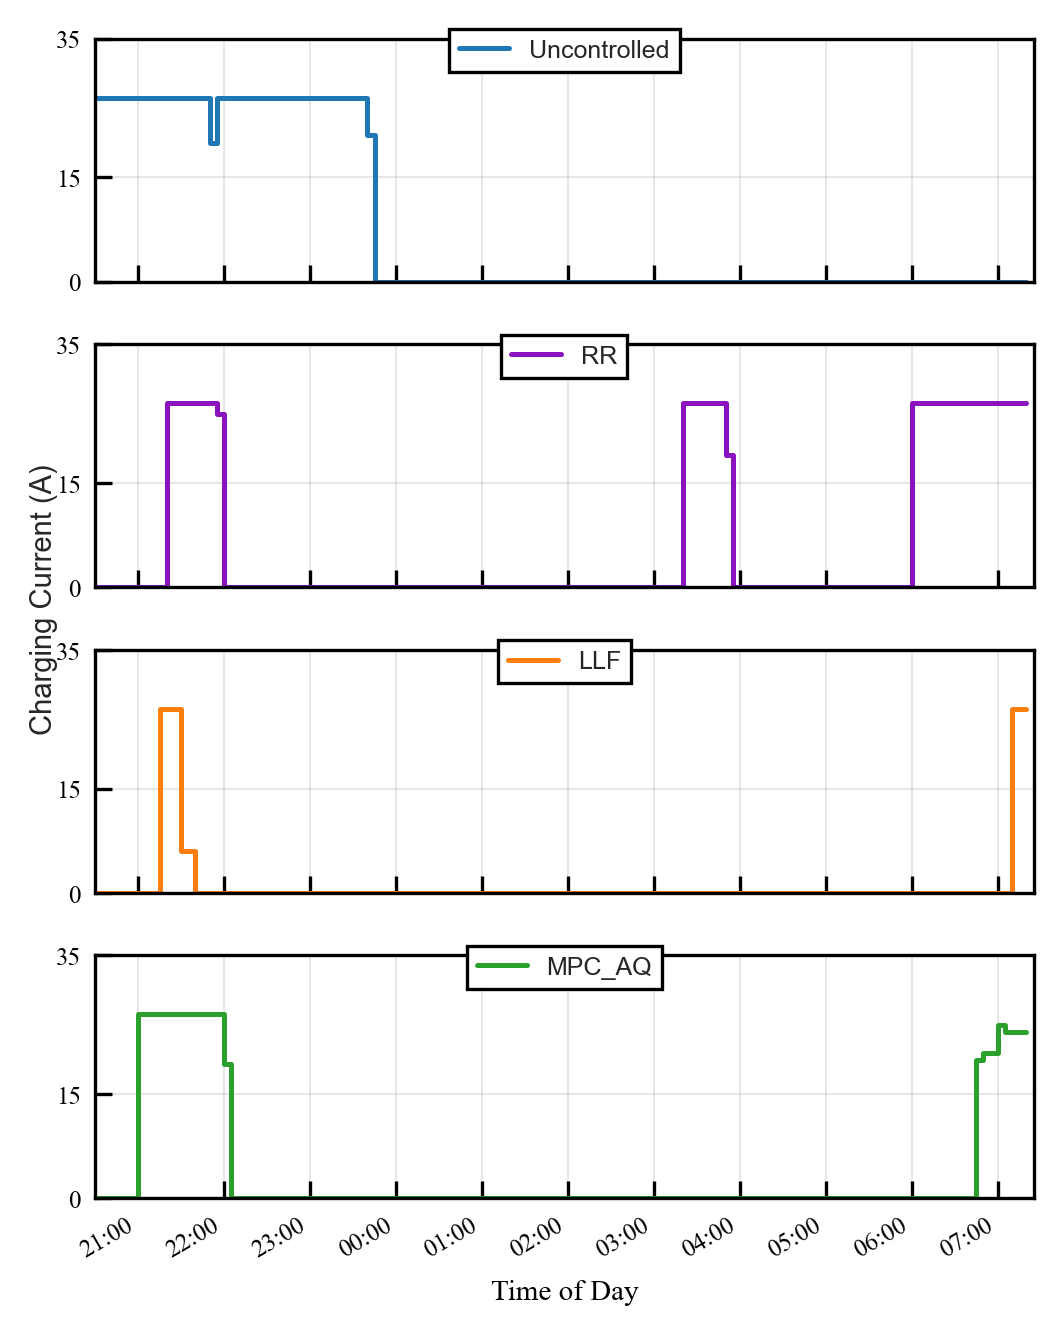

In [47]:
ev = random.choice(list(sims["RR", cap].ev_history.values()))
cap = 100
plot_profiles(sims, cap, ev, label_auto_place=True)

# Saving the plot
plt.tight_layout()
file_basename = "C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\\ev_charging_profiles"
plt.savefig(f"{file_basename}.png", dpi=300, bbox_inches='tight')
print(f"Plot saved as {file_basename}.png")
plt.show()